## 1. Collect Basic Data

### Retrieve CryptoCurrency Market Data ###

In [1]:
import pandas as pd
import yfinance as yf
from functools import reduce
import requests
import time
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


CRYPTO = False

# Crypto Details
cryptoProducts = ["ETH-USD", "USDT-USD", "BTC-USD"]
availableGranularities = dict(zip(["1M", "5M", "15M", "1H", "6H", "1D"], [60, 300, 900, 3600, 21600, 86400]))

# Stock Details
dowTickers = ["AAPL", "MSFT", "GOOGL", "TSLA", "AMZN", "NVDA"]  
sse50Tickers = ["600519.SS", "601318.SS", "601857.SS", "600036.SS", "600016.SS", "600000.SS"]  
sensexTickers = ["RELIANCE.BO", "TCS.BO", "INFY.BO", "ICICIBANK.BO", "SBIN.BO", "HINDUNILVR.BO"] 
ftse100Tickers = ["HSBA.L", "BP.L", "GSK.L", "SHEL.L", "BATS.L", "ULVR.L"]  
period = "1D"
indexProducts = dowTickers + sse50Tickers + sensexTickers + ftse100Tickers
productIds = indexProducts

if CRYPTO:
    productIds = cryptoProducts
    period = "6H"
    granularity = availableGranularities[period]
    API_THRESHOLD = 300 #Can only get 300 periods at a time from API
    PERIODS_WANTED = 2500

# not a chance
def retrieveCryptoData(productID, granularity, daysBack, endTime):
    API_URL = f"https://api.exchange.coinbase.com/products/{productID}/candles"
    daysBackDaysAgo = timedelta(days=daysBack)
    startTime = datetime.fromisoformat(endTime) - (granularity/86400) * daysBackDaysAgo

    # Convert to isoformat
    startTime = startTime.isoformat()

    # Set Request Parameters
    parameters = {
        "start" : startTime,
        "end" : endTime,
        "granularity" : str(granularity)
    }

    # Actually get data
    data = requests.get(API_URL, params = parameters, headers = {"content-type":"application/json"})
    df = pd.DataFrame(data.json(), columns=["time", "low", "high", "open", "close", "volume"])
    return df


def retrieveIndexData(ticker):
    # Define date range
    startDate = "2009-01-01"
    endDate = "2020-08-05"

    ohlcData = {}
    try:
        stockData = yf.download(ticker, start=startDate, end=endDate)
        ohlcData[ticker] = stockData[["Low", "High", "Open", "Close", "Volume"]]
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")

    dfOhlc = pd.concat(ohlcData, axis=1)
    return dfOhlc


dataframes = dict()
RETRIEVE_DATA = False

if RETRIEVE_DATA:
    for productId in productIds:
        if CRYPTO:
            # Fetch PERIODS_WANTED periods of data
            end = (datetime.now()).isoformat()
            for batch in range(PERIODS_WANTED // API_THRESHOLD  + 1):
                amountToFetch = PERIODS_WANTED % API_THRESHOLD if batch == PERIODS_WANTED // API_THRESHOLD else API_THRESHOLD
                tempDF = retrieveCryptoData(productId, granularity, amountToFetch, end)
                timeInSeconds = (tempDF['time'].values)[-1]
                dt = datetime.fromtimestamp(timeInSeconds - granularity)
                end = dt.isoformat() + 'Z'
                value = dataframes.get(productId)
                if productId not in dataframes:
                    dataframes[productId] = tempDF[::-1]
                else:
                    dataframes[productId] = pd.concat([tempDF[::-1], dataframes[productId]])
        else:
            dataframe = retrieveIndexData(ticker=productId)
            columnNames = [value[1].lower() for value in list(dataframe.columns.values)]
            dataframe.columns = columnNames
            dataframes[productId] = dataframe
   
# Required for index data that pull stock data from different exchanges
def commonaliseData(data):
    commonDates = reduce(lambda x, y: x.intersection(y), [df.index for df in data.values()])
    for ticker, df in data.items():
        data[ticker] = df.reindex(commonDates)
        data[ticker]["Times"] = commonDates
    data = {ticker: df.dropna() for ticker, df in data.items()}
    PERIODS_WANTED = data.get(indexProducts[0]).shape[0]
    return data

if not CRYPTO and RETRIEVE_DATA:
    dataframes = commonaliseData(dataframes)

In [2]:
TEST_CORRECT_ORDER = False

if TEST_CORRECT_ORDER:
    testTime = dataframes[productIds[0]]['time'].values
    testTime -= testTime[0]
    plt.figure(figsize=(10, 6))
    plt.plot(testTime, color="blue")
    plt.title(f"Test Correct Order")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.show()

## 2. Augment State Space (add indicators)

### Indicator 1: Exponential Moving Average ###

In [3]:
import matplotlib.pyplot as plt

def EMA(array, N):
    """
    EMA_t = (Price_t * α) + (EMA_(t-1) * (1 - α))
    where:
    EMA_t = Exponential Moving Average at time t
    Price_t = Price at time t
    α (alpha) = Smoothing factor, calculated as 2 / (N + 1)
    N = Number of periods
    """
    smoothingParameter = 2/(N + 1)
    finalArray = [array[0]]
    for i in range(1, len(array)):
        finalArray.append(array[i] * smoothingParameter + finalArray[i-1] * (1 - smoothingParameter))
    return np.array(finalArray)

# expMA = EMA(closingPrices, t)
# plt.figure(figsize=(10, 6))
# plt.plot(expMA, label=f"Exponential Moving Average: T={t}", color="red")
# plt.plot(closingPrices, label="Actual Closing Prices", color="blue")
# plt.title(f"Price Data")
# plt.xlabel("Time")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

### Indicator 2: Momemtum

In [4]:
def Momentum(array):
    # Percentage Change in Price/Time
    momentumArray = [(array[i] - array[i-1]) /array[i-1] for i in range(1, len(array))]
    momentumArray.insert(0, np.nan)
    return np.array(momentumArray)

# momentum = Momentum(closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(momentum*100, color="green")
# plt.title(f"Momentum Data (as %)")
# plt.xlabel("Time")
# plt.ylabel("Momentum")
# plt.legend()
# plt.show()

### Indicator 3: Average True Range

In [5]:

def trueRange(high, low, close):
    # TR = Max[(H - L), |H - C|, |L - C|
    closing = np.insert(close, 0, np.nan, axis=0)[:len(close)]
    return np.maximum(high - low, np.abs(high - closing), np.abs(low - closing))

def averageTrueRange(high, low, close, n=14):
    trueRanges = trueRange(high, low, close)
    atr = np.empty_like(trueRanges)
    atr[:n] = np.nan  # First n values are NaN
    atr[n-1] = np.mean(trueRanges[:n])  # Initial ATR value (simple average of the first n TRs)
    for i in range(n+1, len(trueRanges)):
        atr[i] = (atr[i-1] * (n - 1) + trueRanges[i]) / n
    return atr

# aTRIndicator = averageTrueRange(highs, lows, closingPrices)
# plt.figure(figsize=(10, 6))
# plt.plot(aTRIndicator, color="Brown")
# plt.title(f"Average True Range over Time")
# plt.xlabel("Time")
# plt.ylabel("Average True Range")
# plt.legend()
# plt.show()

### Indicator 4: Commodity Channel Index

In [6]:
def commodityChannelIndex(high, low, close, n=20):
    # (Typical Price - 20_Day Moving Average) / .015 x Mean Deviation
    typicalPrices = (high + low + close) / 3
    
    movingAverage = np.full_like(high, np.nan)
    meanDeviation = np.full_like(high, np.nan)
    
    for i in range(n, len(typicalPrices)):
        movingAverage[i] = np.mean(typicalPrices[i-n:i])
        meanDeviation[i] = np.mean(np.abs(typicalPrices[i-n:i] - movingAverage[i]))
    
    cci = np.full_like(high, np.nan, dtype=np.float64)

    numerator = typicalPrices[n:] - movingAverage[n:]
    denominator = 0.015 * meanDeviation[n:]
    result = np.empty_like(numerator)

    np.divide(numerator, denominator, out=result, where=(denominator != 0))
    # a little hacky...
    result[denominator == 0] = 0

    cci[n:] = result
    return cci

# # CCI = commodityChannelIndex(highs, lows, closingPrices)
# # plt.figure(figsize=(10, 6))
# # plt.plot(CCI, color="black")
# # plt.title(f"Commodity Channel Index over Time")
# # plt.xlabel("Time")
# # plt.ylabel("Commodity Channel Index")
# # plt.legend()
# # plt.show()

### Indicator 5: MACD

In [7]:
"""
MACD = 12-day EMA - 26-day EMA
Signal Line = 9-day EMA of MACD
MACD Histogram = MACD - Signal Line
where EMA stands for Exponential Moving Average
"""

def MACD(array):
    return EMA(array, 12) - EMA(array, 26)

def MACDSignal(array):
    return EMA(MACD(array), 9)

MACDHistogram = lambda x : MACD(x) - MACDSignal(x)

# mACD = MACD(closingPrices)
# signalLine = MACDSignal(closingPrices)
# macdHistogram = MACDHistogram(mACD, signalLine)

# plt.figure(figsize=(10, 6))
# plt.plot(mACD, color="blue", label = "MACD Line")
# plt.plot(signalLine, color = "red", label = "Signal Line")
# plt.plot(macdHistogram, color = "black", label = "Histogram")
# plt.title(f"Moving Average Convergence-Divergence")
# plt.xlabel("Time")
# plt.ylabel("MACD")
# plt.legend()
# plt.show()

## 3. Collate All Features Into DataFrame

In [8]:
import os

CCI_T, ATR_T = 20, 14
if RETRIEVE_DATA:
    for product in productIds:
        df = dataframes[product]
        close = df["close"].values
        highs = df["high"].values
        lows = df["low"].values
        df['E_M_A'] = EMA(close, N=30)
        df['Momentum'] = Momentum(close)
        df['Av_True_Range'] = averageTrueRange(highs, lows, close, 14)
        df['CCI'] = commodityChannelIndex(highs, lows, close, 20)
        df['MACDHist'] = MACDHistogram(close)
        df["Return"] = df["close"].pct_change().fillna(0)
        # Reset Indexes
        df = df.drop(columns=['open', 'high', 'volume', 'low'])
        df = df.iloc[max(ATR_T, CCI_T):]
        df = df.reset_index(drop=True)
        dataframes[product] = df
        if not os.path.exists("CSVs/"):
            os.makedirs("CSVs/")
        df.to_csv(f"CSVs/{product}_{period}_periods.csv", sep='\t')
else:
    for productId in productIds:
        df = pd.read_csv(f"CSVs/{productId}_{period}_periods.csv", sep='\t')
        dataframes[productId] = df.iloc[:, 1:]  # Drops the first column

times = None
if not CRYPTO:
    for product in productIds:
        df = dataframes[product]
        times = df['Times']
        dataframes[product] = df.drop('Times', axis=1)

## 4. Environment and Training Process

### Comparison Strategies

In [9]:
sse50BuyAndHold =  np.array([0] + [1/len(sse50Tickers) if i in sse50Tickers else 0 for i in productIds])
sensexBuyAndHold = np.array([0] + [1/len(sensexTickers) if i in sensexTickers else 0 for i in productIds])
ftse100BuyAndHold = np.array([0] + [1/len(ftse100Tickers) if i in ftse100Tickers else 0 for i in productIds])
dowBuyAndHold = np.array([0] + [1/len(dowTickers) if i in dowTickers else 0 for i in productIds])
buyAndHoldAll = np.array([0] + [1/(len(productIds)) for i in productIds])

#Non
NON_RL_COMPARISON_STRATEGIES = {
    "SSEBuyAndHold" : sse50BuyAndHold,
    "SENSEXBuyAndHold" : sensexBuyAndHold,
    "FTSEBuyAndHold" : ftse100BuyAndHold,
    "DOWBuyAndHold" : dowBuyAndHold,
    "BuyAndHoldAll" : buyAndHoldAll
}

### Hyperparameters (most of them)

In [10]:
from collections import defaultdict


NUMBER_OF_ASSETS = len(productIds)
NUMBER_OF_FEATURES = 1 + (len((list(dataframes.values())[0]).columns)) * len(productIds)
if not CRYPTO:
    PERIODS_WANTED = list(dataframes.values())[0].shape[0]
EXPERIMENTS = 2
TRAINING_PERIODS = int(PERIODS_WANTED / EXPERIMENTS) # will probably have to change this to times
TIME_WINDOW = 30
LEARNING_FREQUENCIES = (TRAINING_PERIODS / np.array([10, 20, 30, 40, 50])).astype(int)
START_CASH = 1000000
LSTMHIDDENSIZE = 128
AGENT_RISK_AVERSIONS = np.array([0.25, 0.5, 1, 1.5, 2]) #i know, this probably shouldn't go here
STRATEGIES = ["PPOLSTM", "RANDOM"]#, "TD3"] #td3 requires debugging - dont run
FINAL_STRATEGIES = STRATEGIES + ["SSEBuyAndHold", "SENSEXBuyAndHold", "FTSEBuyAndHold", "DOWBuyAndHold", "BuyAndHoldAll"]
REPEATS = 5 # Computational Limitations
LSTMOUTPUTSIZES = [64, 128, 256, 512, 1024]
STARTS = [0] + [i *  TRAINING_PERIODS + -TIME_WINDOW for i in range(1, EXPERIMENTS)]
PORTFOLIO_TRAJECTORIES = []
REWARD_FUNCTIONS = ["Standard Logarithmic Returns" ,"Differential Sharpe Ratio_0.01", "Differential Sharpe Ratio_0.05", "Differential Sharpe Ratio_0.1", "CVaR"]
NUMBER_OF_PARALLEL_ENVIRONMENTS = [0, 1, 2, 3, 4]
LEARNING_RATES = [1e-4, 3e-4, 5e-4, 7e-4]
RL_STRATS = ["PPOLSTM"]#, "TD3"]
averagePerformance = defaultdict(list)
allResults = defaultdict(list)

In [11]:
# Thing being tested
TESTING = {
    "RISK AVERSION" : False,
    "LSTM OUTPUT SIZE" : False,
    "REWARD FUNCTION" : False,
    "LEARNING FREQUENCY": False, 
    "PARALLEL ENVIRONMENTS" : False, 
    "LEARNING RATE": False,
}

#### Some helper functions for metrics

In [12]:
from utils import tabulate_neatly

def printConfiguration(agent=None, freq=None):
    table = [["LSTM Hidden Size", "LSTM Output Size", "Learning Frequency", "Agent Risk Aversion"]]
    table.append([LSTMHIDDENSIZE, agent.state_n, freq, agent.riskAversion])
    tabulate_neatly(table, headers="firstrow", title=f"Configuration:")

def plotAllocations(allocations, title=None):
    categories = ['Cash'] + productIds
    plt.figure(figsize=(20,5))
    plt.bar(categories, allocations)
    plt.xlabel('Allocations')
    plt.tick_params(axis='x', labelsize=6)
    plt.ylabel('Proportion Allocated')
    plt.title('Allocations' if title == None else title)
    plt.show()

def generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr):
    firstTag = f"Strategy-{strategy}" 
    lastTag = f"Experiment {episode + 1}"
    innerTag = None
    boole = (strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM")
    if TESTING["RISK AVERSION"]:
        innerTag = (f"Risk Aversion-{agent.riskAversion}" if boole else "")
    elif TESTING["LSTM OUTPUT SIZE"]:
        innerTag = (f"LSTM Output Size-{agent.state_n}" if boole else "")
    elif TESTING["REWARD FUNCTION"]:  
        innerTag = (f"Reward Function-{rewardFunction}" if boole else "")
    elif TESTING["LEARNING FREQUENCY"]:  
        innerTag = (f"Learning Frequency-{freq}" if boole else "")
    elif TESTING["PARALLEL ENVIRONMENTS"]:  
        innerTag = (f"Parallel Environments-{parr}" if boole else "")
    elif TESTING["LEARNING RATE"]:  
        innerTag = (f"Learning Rate-{lr}" if boole else "")
    
    if any(TESTING.values()) and boole:
        firstTag, innerTag = innerTag, firstTag
    return firstTag + " | " +  innerTag + " | " + lastTag


### Actual Training

In [13]:
from PPO import PPOAgent
from TD3 import TD3Agent

def generateAgent(strat, lstmOutputSize, riskAversion, lr):
    if strat == "TD3":
        return TD3Agent(
                state_n=lstmOutputSize,
                actions_n=len(productIds) + 1,
                alpha=lr,
                beta=0.001,
                gamma=0.99,
                tau=0.005,
                lstmHiddenSize = LSTMHIDDENSIZE,
                actor_noise=0.01,
                target_noise=0.01,
                env=None,
                batch_size=128,
                fc1_n=512,
                fc2_n=384,
                riskAversion=riskAversion,
            )
    elif strat == "PPOLSTM":
        return PPOAgent( 
                        state_n=lstmOutputSize, 
                        actions_n=len(productIds) + 1,
                        alpha=lr,
                        policyClip = 0.2,
                        gamma=0.99,
                        lstmHiddenSize=LSTMHIDDENSIZE,
                        actor_noise=0,
                        batch_size=512,
                        fc1_n=128,
                        fc2_n=128,
                        gaeLambda=0.98,
                        epochs=10,
                        riskAversion=riskAversion,
                    )

In [14]:
import torch
from PPO import PPOAgent
from TD3 import TD3Agent
from LstmFeatureExtractor import LstmFeatureExtractor
from TimeSeriesEnvironment import TimeSeriesEnvironment
from scipy.special import softmax
import numpy as np

seed = 0
torch.manual_seed(seed)
np.random.seed(seed)

def initializeEnvironments(start, parr, rewardFunction, riskAversion, strategy):
    primaryEnvironment = TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
    parallelEnvironments = [
        TimeSeriesEnvironment(dataframes, start, TIME_WINDOW, TRAINING_PERIODS, START_CASH, riskAversion, 2.5e-4)
        for _ in range(parr)
    ]
    primaryEnvironment.TD3 = strategy == "TD3"
    for parallel in parallelEnvironments:
        parallel.TD3 = strategy == "TD3"
    if "Differential" in rewardFunction:
        decay = float(rewardFunction.split("_")[1])
        primaryEnvironment.decayRate = decay
        for env in parallelEnvironments:
            env.decayRate = decay
    return primaryEnvironment, parallelEnvironments

def storeExperiences(agent, data, outputs, reward, done, strategy, parr, action, prob, val, next):
        if strategy == "PPOLSTM":
            agent.store(data, action, prob.squeeze(), val.squeeze(), reward, done)
            for i in range(parr):
                agent.store(
                    data,
                    outputs["actions"][i],
                    outputs["probabilities"][i].squeeze(),
                    outputs["valuations"][i].squeeze(),
                    float(outputs["rewards"][i]),
                    bool(outputs["dones"][i])
                )
        elif strategy == "TD3":
            agent.store(
                data,
                action,
                reward,
                next, 
                done,
            )
            for i in range(parr):
                agent.store(
                    data,
                    outputs["actions"][i],
                    float(outputs["rewards"][i]),
                    next,
                    bool(outputs["dones"][i])
                )


def warmUpEnvironment(environment, strategy, parallelEnvironments, rewardFunction):
    """
    'warm up' primaryEnvironmentironment until there's enough data to calculate CVaR
    """
    for _ in range(TIME_WINDOW):
        allocations = np.random.normal(scale=1, size=len(productIds))
        allocations = np.insert(allocations, 0, 1)
        environment.step(softmax(allocations), False, rewardMethod=rewardFunction)
        if strategy in RL_STRATS:
            for parallel in parallelEnvironments:
                parallel.step(softmax(allocations), False, rewardMethod=rewardFunction)
    environment.setIsReady(True)
    if strategy in RL_STRATS:
        for parallel in parallelEnvironments:
            parallel.setIsReady(True)
            parallel.TD3 = strategy == "TD3"

def trainingLoop(riskAversion=0, lstmOutputSize=512, rewardFunction="CVaR", freq=int(TRAINING_PERIODS / 25), parr=0, lr=3e-4, expers = None, conf = None):
    for repeat in range(REPEATS):
        for strategy in STRATEGIES:
            if repeat > 0 and strategy not in (RL_STRATS + ["RANDOM"]):
                continue
            
            LB, UB = 0, EXPERIMENTS
            if expers != None:
                LB, UB = expers[0], expers[1]
            for episode in range(LB, UB, 1):
                start = episode * TRAINING_PERIODS + (0 if episode == 0 else -TIME_WINDOW)
                featureExtractor = LstmFeatureExtractor(TIME_WINDOW, NUMBER_OF_FEATURES, 128, lstmOutputSize)
                agent = generateAgent(strategy, lstmOutputSize, riskAversion, lr)
                primaryEnvironment, parallelEnvironments = initializeEnvironments(start, parr, rewardFunction, riskAversion, strategy)
                primaryEnvironment.reset()
                done, doNothing = False, False

                while not done:
                    if not primaryEnvironment.getIsReady():
                        warmUpEnvironment(primaryEnvironment, strategy, parallelEnvironments, rewardFunction)
                        continue

                    readyToStartTrading = (primaryEnvironment.timeStep) / TRAINING_PERIODS >= 2 / 3
                    observation, outputs = None, None

                    if strategy in RL_STRATS:
                        data = primaryEnvironment.getData()
                        observation = featureExtractor.forward(torch.tensor(data, dtype=torch.float32).unsqueeze(0))
                        if strategy == "PPOLSTM":
                            outputs = {
                                "actions": torch.zeros(parr, agent.actions_n),
                                "probabilities": torch.zeros(parr, agent.actions_n),
                                "valuations": torch.zeros(parr, 1),
                                "rewards": torch.zeros(parr, 1),
                                "dones": torch.zeros(parr, 1)
                            }
                            for i in range(parr):
                                act, prob, val = agent.select_action(observation)
                                outputs["actions"][i] = act
                                outputs["probabilities"][i] = prob
                                outputs["valuations"][i] = val
                        else:
                            outputs = {
                                "nextstates" : torch.zeros(parr, agent.state_n),
                                "actions" : torch.zeros(parr, agent.actions_n),
                                "rewards" : torch.zeros(parr, 1),
                                "dones" : torch.zeros(parr, 1)
                            }
                            for i in range(parr):
                                act = agent.select_action(observation)
                                outputs["actions"][i] = act # noise added to action so its fine
                        allCashAction = np.array([1] + [0 for _ in productIds]) if doNothing else None

                    probabilities, valuation = None, None
                    if strategy == "RANDOM":
                        action = np.random.normal(0, 1, len(productIds) + 1)

                    elif strategy in NON_RL_COMPARISON_STRATEGIES:
                        action = NON_RL_COMPARISON_STRATEGIES.get(strategy)
                    else: 
                        if strategy == "PPOLSTM":
                            action, probabilities, valuation = agent.select_action(observation)
                        elif strategy == "TD3":
                            action = agent.select_action(observation) 
                            
                    if not doNothing:
                        primaryEnvironment.traded += 1

                    finalAction = (
                        allCashAction if doNothing else ([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES else softmax(action))
                    )
                    next, reward, done, _, info = primaryEnvironment.step(finalAction, readyToStartTrading, rewardFunction)
                    
                    if strategy in RL_STRATS:
                        for i in range(parr):
                            nexts, rew, do, _, _ = parallelEnvironments[i].step(finalAction, readyToStartTrading, rewardFunction)
                            if strategy == "TD3":
                                outputs["nextstates"][i] = nexts
                            outputs["rewards"][i] = rew
                            outputs["dones"][i] = int(do)
                        if not doNothing:
                            storeExperiences(agent, data, outputs, reward, done, strategy, parr, action, probabilities, valuation, next)
                            doNothing = info["turbulence_breached"]
                        if (primaryEnvironment.timeStep % freq) == 0:
                            agent.train(featureExtractor)

                    if done:
                        dataString = None
                        if conf == None or strategy == "RANDOM":
                            dataString = generateConfigLabel(strategy, agent, episode, rewardFunction, freq, parr, lr)
                        else:
                            dataString = conf
                        averagePerformance[dataString].append(primaryEnvironment.PORTFOLIO_VALUES)
                        metrics = primaryEnvironment.getMetrics()
                        allResults[dataString].append(metrics)
                        table = [metrics.keys()]
                        table.append(metrics.values())
                        tabulate_neatly(table, headers="firstrow", title=f"{dataString}")
                        # if strategy not in NON_RL_COMPARISON_STRATEGIES.keys() and strategy != "RANDOM":
                            #nice but take up way too much space...
                            # printConfiguration(agent, freq)
                            # plotAllocations([0] + action if strategy in NON_RL_COMPARISON_STRATEGIES.keys() else softmax(action), "Final Allocations")
                        

### Visualise Performance ###

In [15]:
if not CRYPTO:
    result = np.array_split(times, STARTS, axis=0)[1:]
    timeScale = [dates for dates in result]

def plotPerformance(test, final=""):
    for experiment in range(EXPERIMENTS):
        plt.figure(figsize=(12,6))
        relevantPeriods = int(2/3 * TRAINING_PERIODS) + 2
        name = f"Experiment_{experiment + 1}_" 
        portfolioFolder = f"portfolios/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
        plotsFolder = f"plots/Test-{test+final}/"+ datetime.now().strftime("%Y-%m-%d") + "/"
        if not os.path.exists(portfolioFolder):
            os.makedirs(portfolioFolder)
        if not os.path.exists(plotsFolder):
            os.makedirs(plotsFolder)
        for k, v in averagePerformance.items():
            # if test.lower() in k.lower() or "RANDOM" in k: # i wrote this at 12am forgive me
            #     shouldBeSkipped = False
            #     for value in list(NON_RL_COMPARISON_STRATEGIES.keys())[:-1]:
            #         if value in k:
            #             shouldBeSkipped = True # only need to compare with buy and hold for now
            #     if shouldBeSkipped:
            #         continue
                try:
                    x = np.array(v)
                    x = np.mean(v, axis=0)
                    v = x
                except ValueError:
                    maxLength = max(len(arr) for arr in v)
                    result = []
                    for i in range(maxLength):
                        values = [arr[i] for arr in v if i < len(arr)]
                        mean_value = np.mean(values)
                        result.append(mean_value)
                    v = result
                v= v[relevantPeriods:]
                if f"Experiment {experiment + 1}" in k:
                    l = k.split("|")[0]
                    array = np.insert(v, 0, START_CASH)
                    # labels = timeScale[experiment][-15:]           
                    # labelIndices = range(0, len(labels), 1)  
                    # plt.xticks(labelIndices, rotation=45)
                    plt.plot(array, label=l) ## too tired
                    np.savetxt(f"{portfolioFolder}{name}{l}.txt", array, fmt='%f')
        plt.title(f"Returns over Time - Experiment {experiment + 1}. Testing: {test}")
        plt.xlabel("Time")
        plt.ylabel("Mean Returns")
        plt.legend()
        plt.savefig(f"{plotsFolder}{name}")
        plt.show()



C:\Users\bluem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


### Tabulate Results

In [16]:
def tabulateResults():
    for k, v in allResults.items():
        table = [list(v[0].keys()) + ["Standard Deviation"]] 
        meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps = 0, 0, 0, 0, 0, 0
        deviations = []
        for resultSet in v:
            meanReturns += resultSet["Cumulative \nReturn (%)"]
            deviations.append(resultSet["Cumulative \nReturn (%)"])
            meanMER += resultSet["Maximum Earning \nRate (%)"]
            meanPB += resultSet["Maximum \nPullback (%)"]
            meanAPPT += (resultSet["Average Profitability \nper Trade"] if type(resultSet["Average Profitability \nper Trade"]) == float else 0)
            meanSR += resultSet["Sharpe Ratio"]
            timeSteps += resultSet["Total Timesteps"]
        array = [meanReturns, meanMER, meanPB, meanAPPT, meanSR, timeSteps, np.std(deviations)]
        array = [i/len(v) for i in array]
        table.append(array)
        tabulate_neatly(table, headers="firstrow", title=f"MEAN RESULTS FOR: " + k)

In [17]:
def test():
    for testType, active in TESTING.items():
        if active:
            print(f"TESTING {testType.replace('_', ' ').upper()}")
            testLoops = {
                "RISK AVERSION": lambda: [
                    trainingLoop(riskAversion=risk) for risk in AGENT_RISK_AVERSIONS
                ],
                "LSTM OUTPUT SIZE": lambda: [
                    trainingLoop(lstmOutputSize=size) for size in LSTMOUTPUTSIZES
                ],
                "REWARD FUNCTION": lambda: [
                    trainingLoop(
                        riskAversion=(0.25 if r == "CVaR" else 0), rewardFunction=r
                    )
                    for r in REWARD_FUNCTIONS
                ],
                "LEARNING FREQUENCY": lambda: [
                    trainingLoop(freq=fr) for fr in LEARNING_FREQUENCIES
                ],
                "PARALLEL ENVIRONMENTS": lambda: [
                    trainingLoop(parr=par) for par in NUMBER_OF_PARALLEL_ENVIRONMENTS
                ],
                "LEARNING RATE": lambda: [
                    trainingLoop(lr=learn) for learn in LEARNING_RATES
                ],
            }
            
            testLoops[testType]()
            break 


def runTests():
    for key in TESTING.keys():
        print("=" * 50)
        TESTING[key] = True
        test()
        plotPerformance(key)
        TESTING[key] = False
        print("=" * 50)
    tabulateResults()

TEST = False
# Run the tests
if TEST:
    runTests()

### Best Models (if any) Evaluated 

Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
44.46,52.35,19.7407,1214.78,0.1124,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.07,29.14,34.3292,712.179,0.0754,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
55.44,56.9,49.1528,1514.78,0.1339,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.56,29.63,41.6521,534.477,0.057,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
15.48,32.95,42.7347,422.903,0.0406,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.1,37.35,41.8555,877.028,0.09,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
17.06,18.56,27.2647,466.206,0.0574,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.52,45.85,32.6461,1134.3,0.1058,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
47.74,53.39,41.7568,1304.27,0.1088,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.33,35.26,46.7022,828.674,0.0871,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.1,27.1,36.1657,494.569,0.048,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
37.56,41.36,27.8781,1026.26,0.0999,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
12.21,19.03,34.0157,333.554,0.0368,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.24,22.05,36.6334,443.769,0.0489,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
38.37,53.4,34.0407,1048.31,0.0938,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.75,41.05,41.2799,1003.98,0.0883,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.37,33.18,28.7895,747.771,0.0808,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.34,37.33,35.9508,856.348,0.0861,1101


Reward Function-Standard Logarithmic Returns | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
22.41,26.3,22.5134,612.24,0.0667,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.87,33.36,29.6563,597.467,0.0633,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.11,32.32,34.0355,850.028,0.0893,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.28,27.75,25.525,690.67,0.074,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.09,34.87,37.1833,876.672,0.0802,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.35,45.64,40.4129,993.129,0.0954,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.92,27.48,26.8313,735.462,0.0793,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.72,37.44,37.425,893.968,0.094,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
42.09,46.23,42.0804,1149.93,0.0923,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
34.39,40.17,26.0907,939.73,0.0916,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
52.72,60.95,29.5142,1440.53,0.1129,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.38,25.42,42.0421,584.286,0.063,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
49.23,53.22,22.9313,1345.12,0.1155,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
25.53,31.36,30.9989,697.466,0.073,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
24.38,31.2,44.4072,666.02,0.0623,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.72,27.49,37.5886,374.753,0.0393,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
20.7,26.25,34.9718,565.52,0.0564,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
9.07,20.47,26.1485,247.943,0.0265,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
18.95,32.55,20.157,517.772,0.0529,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
45.86,53.34,33.7768,1253.03,0.1121,1101


Reward Function-Differential Sharpe Ratio_0.1 | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
16.03,26.36,45.3587,437.948,0.0457,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
31.03,34.6,38.2155,847.745,0.0887,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
32.67,50.47,39.6474,892.585,0.0626,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
21.49,36.62,39.8197,587.184,0.0545,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
45.81,49.65,37.6276,1251.59,0.103,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
36.29,41.54,33.9739,991.623,0.0986,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.45,33.49,23.4947,750.062,0.0703,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
23.92,28.94,36.9573,653.531,0.0686,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.81,41.19,47.9447,759.766,0.0618,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
27.16,36.98,28.2452,741.993,0.0774,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
51.92,60.4,28.7346,1418.68,0.1141,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.02,35.67,39.8055,765.473,0.0796,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.24,27.42,20.753,525.577,0.058,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
30.8,38.02,27.1622,841.58,0.0805,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
13.99,19.43,20.2421,382.331,0.0429,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
28.35,37.85,40.9794,774.595,0.0775,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
45.85,55.09,35.6772,1252.74,0.1069,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
26.75,33.77,28.041,730.901,0.0747,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
11.61,24.16,44.9977,317.251,0.0375,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
19.56,24.61,33.9912,534.306,0.0575,1101


Reward Function-CVaR | Strategy-PPOLSTM | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
41.56,46.93,22.3495,1135.5,0.1045,1101


Strategy-RANDOM | | Experiment 1

Cumulative Return (%),Maximum Earning Rate (%),Maximum Pullback (%),Average Profitability per Trade,Sharpe Ratio,Total Timesteps
29.23,37.16,30.7821,798.631,0.0831,1101


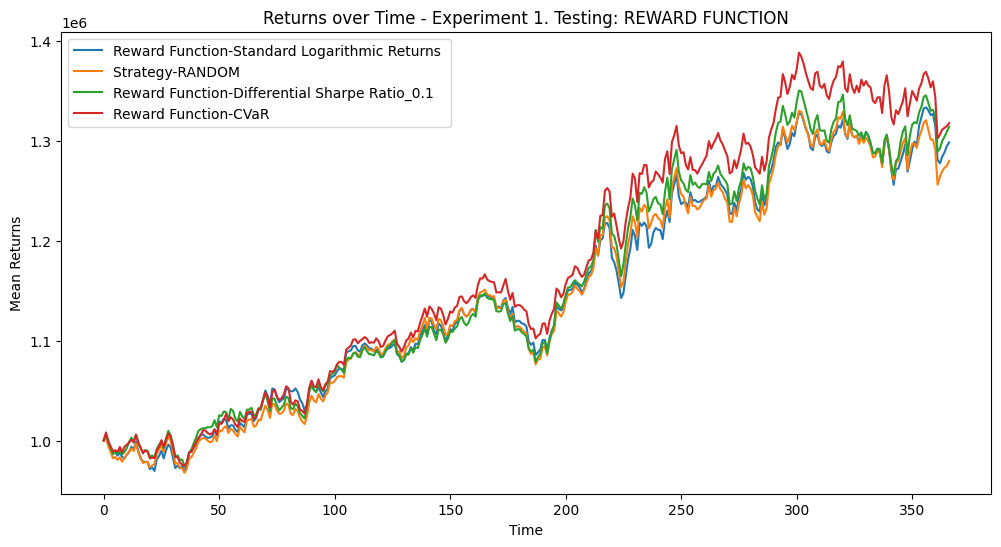

C:\Users\bluem\AppData\Local\Temp\ipykernel_40336\2909671760.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


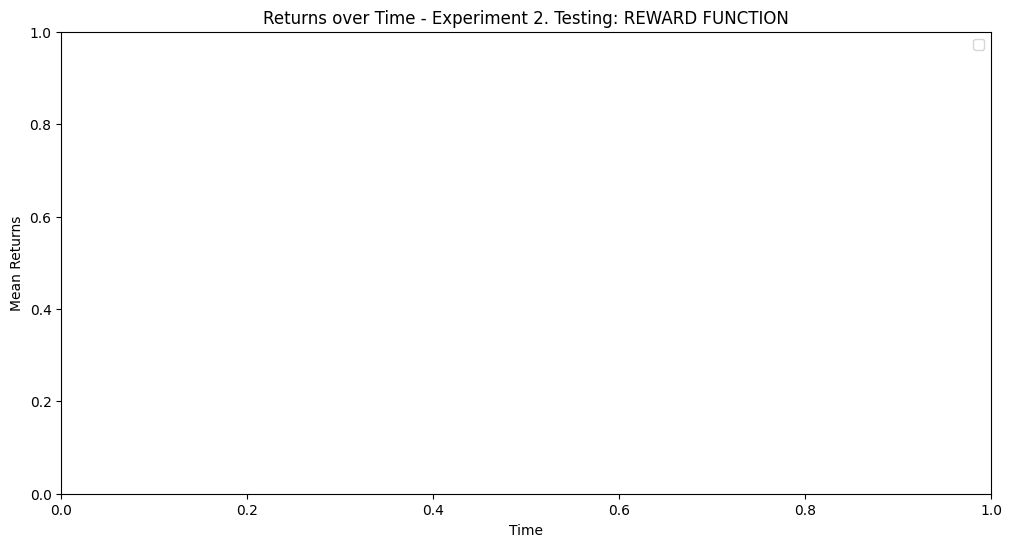

In [19]:
# REMEMBER TO VARY BUT REPEAT SEEDS
# To test:
# Exp 1:
# RF: RiskAversion = 0.25, DSR = 0.1. LogRet
# Output Size = 256
# Frequency = 36
# Envs = 3
# LR = 5e-4

# Exp 2:
# RF: RiskAversion = 0.5, 1.5, CVaR, LogRet
# Output Size = 1024
# Frequency = 36
# Envs = 0
# LR = 3e-4

REPEATS = 10

# Experiment 1
EXP_1_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "Differential Sharpe Ratio_0.1", "CVaR"],
                "LSTM Output Size" : 256, 
                "Frequency" : 36,
                "Environments" : 3,
                "Learning Rate" : 5e-4,
                }
EXP_2_CONFIG = {"Reward" : ["Standard Logarithmic Returns", "CVaR_0.5", "CVaR_1.5"],
                "LSTM Output Size" : 1024, 
                "Frequency" : 36,
                "Environments" : 0,
                "Learning Rate" : 3e-4,
                }


CONFIG_1 = True
CONFIG_2 = False

def runFinal():
    #terrible code forgive me
    global allResults 
    allResults = defaultdict(list)
    # Configuration 1
    if CONFIG_1:
        print("=" * 50)
        TESTING["REWARD FUNCTION"] = True
        for r in EXP_1_CONFIG["Reward"]:
            trainingLoop(
            riskAversion=(0.25 if r == "CVaR" else 0),
            rewardFunction=r,
            freq=EXP_1_CONFIG["Frequency"],
            parr=EXP_1_CONFIG["Environments"],
            lstmOutputSize=EXP_1_CONFIG["LSTM Output Size"],
            lr=EXP_1_CONFIG["Learning Rate"],
            expers=(0, 1),
            conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 1",
        )
        plotPerformance("REWARD FUNCTION", "SecondLast")
        TESTING["REWARD FUNCTION"] = False
        print("=" * 50)

    allResults = defaultdict(list)

    if CONFIG_2:
        # Configuration 2
        print("=" * 50)
        TESTING["REWARD FUNCTION"] = True
        for r in EXP_2_CONFIG["Reward"]:
            trainingLoop(
            riskAversion=(float(r.split("_")[1]) if r.split("_")[0] == "CVaR" else 0),
            rewardFunction=r.split("_")[0],
            freq=EXP_2_CONFIG["Frequency"],
            parr=EXP_2_CONFIG["Environments"],
            lstmOutputSize=EXP_2_CONFIG["LSTM Output Size"],
            lr=EXP_2_CONFIG["Learning Rate"],
            expers=(1, 2),
            conf = "Reward Function-" + r + " | " + "Strategy-PPOLSTM" + " | " + "Experiment 2",
        )
        plotPerformance("REWARD FUNCTION", "ThirdLast")
        TESTING["REWARD FUNCTION"] = False
        print("=" * 50)
    
    tabulateResults()

RUN_FINAL = True
if RUN_FINAL:
    runFinal()
